In [41]:
import pandas as pd
import numpy as np
import networkx as nx
import gzip as gz
import json
import pickle
import torch

import seaborn as sns
import matplotlib.pyplot as plt

## Data Preperation

# Import valid_pairs data

### Basic Info 

In [5]:
# Import the valid pairs in csv
valid_pairs = pd.read_csv("../../data/valid_pairs.csv")
valid_pairs.head(5)

,source,destination,design,source_feature_1,source_feature_2,source_feature_3,source_feature_4,source_feature_5,source_feature_6,source_feature_7,...,destination_feature_36,destination_feature_37,destination_feature_38,destination_feature_39,destination_feature_40,destination_feature_41,destination_feature_42,destination_feature_43,destination_feature_44,destination_feature_45
0,353995,354640,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,7.0,12.0,16.0,28.0,1.0,27.0,24.0,22.0,75.0,96.0
1,353995,597064,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,5.0,7.0,12.0,16.0,27.0,24.0,22.0,75.0,96.0,89.0
2,353995,354008,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,14.0,27.0,25.0,31.0,1.0,1.0,1.0,5.0,5.0,10.0
3,353995,354009,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,14.0,24.0,33.0,31.0,1.0,1.0,5.0,5.0,10.0,14.0
4,380021,277279,1,64.0,0.0002,0.0,6.0,3.0,0.000023,0.000021,...,13.0,15.0,23.0,25.0,1.0,1.0,3.0,2.0,5.0,6.0


In [12]:
# Number of pairs found and the number of features
vp_shape = valid_pairs.shape
print("number of pairs: " + str(vp_shape[0]))
print("number of features: " + str(vp_shape[1]))

number of pairs: 68862
number of features: 93


In [17]:
# All the 93 features of the df
print(valid_pairs.columns)

Index(['source', 'destination', 'design', 'source_feature_1',
       'source_feature_2', 'source_feature_3', 'source_feature_4',
       'source_feature_5', 'source_feature_6', 'source_feature_7',
       'source_feature_8', 'source_feature_9', 'source_feature_10',
       'source_feature_11', 'source_feature_12', 'source_feature_13',
       'source_feature_14', 'source_feature_15', 'source_feature_16',
       'source_feature_17', 'source_feature_18', 'source_feature_19',
       'source_feature_20', 'source_feature_21', 'source_feature_22',
       'source_feature_23', 'source_feature_24', 'source_feature_25',
       'source_feature_26', 'source_feature_27', 'source_feature_28',
       'source_feature_29', 'source_feature_30', 'source_feature_31',
       'source_feature_32', 'source_feature_33', 'source_feature_34',
       'source_feature_35', 'source_feature_36', 'source_feature_37',
       'source_feature_38', 'source_feature_39', 'source_feature_40',
       'source_feature_41', 'source_

In [36]:
types = valid_pairs.dtypes
types.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

### Pair Uniqueness

In [ ]:
# Check if all the pairs are unique
vp_copy = valid_pairs.copy()
vp_copy['pair'] = vp_copy.apply(lambda row: tuple(sorted([row['source'], row['destination']])), axis=1)

unique_pairs_count = vp_copy['pair'].nunique()
print("number of unique pairs: " + str(unique_pairs_count) + "/68862")

number of unique pairs: 68860/68862


In [16]:
vp_copy.head()

,source,destination,design,source_feature_1,source_feature_2,source_feature_3,source_feature_4,source_feature_5,source_feature_6,source_feature_7,...,destination_feature_37,destination_feature_38,destination_feature_39,destination_feature_40,destination_feature_41,destination_feature_42,destination_feature_43,destination_feature_44,destination_feature_45,pair
0,353995,354640,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,12.0,16.0,28.0,1.0,27.0,24.0,22.0,75.0,96.0,"(353995.0, 354640.0)"
1,353995,597064,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,7.0,12.0,16.0,27.0,24.0,22.0,75.0,96.0,89.0,"(353995.0, 597064.0)"
2,353995,354008,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,27.0,25.0,31.0,1.0,1.0,1.0,5.0,5.0,10.0,"(353995.0, 354008.0)"
3,353995,354009,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,24.0,33.0,31.0,1.0,1.0,5.0,5.0,10.0,14.0,"(353995.0, 354009.0)"
4,380021,277279,1,64.0,0.0002,0.0,6.0,3.0,0.000023,0.000021,...,15.0,23.0,25.0,1.0,1.0,3.0,2.0,5.0,6.0,"(277279.0, 380021.0)"


Most of the valid pairs are unique with the exception of 1 non-unique pair. Given the limited amount of non-unique pairs, we choose to leave it since it will not impact the future exploratory data analysis.

### Separate pairs based on design

In [ ]:
# Extract valid pairs from design1
design1 = valid_pairs[valid_pairs['design'] == 1]
design1.head()

,source,destination,design,source_feature_1,source_feature_2,source_feature_3,source_feature_4,source_feature_5,source_feature_6,source_feature_7,...,destination_feature_36,destination_feature_37,destination_feature_38,destination_feature_39,destination_feature_40,destination_feature_41,destination_feature_42,destination_feature_43,destination_feature_44,destination_feature_45
0,353995,354640,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,7.0,12.0,16.0,28.0,1.0,27.0,24.0,22.0,75.0,96.0
1,353995,597064,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,5.0,7.0,12.0,16.0,27.0,24.0,22.0,75.0,96.0,89.0
2,353995,354008,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,14.0,27.0,25.0,31.0,1.0,1.0,1.0,5.0,5.0,10.0
3,353995,354009,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,14.0,24.0,33.0,31.0,1.0,1.0,5.0,5.0,10.0,14.0
4,380021,277279,1,64.0,0.0002,0.0,6.0,3.0,0.000023,0.000021,...,13.0,15.0,23.0,25.0,1.0,1.0,3.0,2.0,5.0,6.0


In [29]:
# Correlation matrix of the valid pairs in design1
design1_feats = design1.iloc[:, 3:]
d1_corr = design1_feats.corr()

# Unstack the correlation matrix to get pairs of features and their correlation values
corr_pairs = d1_corr.unstack()

# Filter out pairs that have a correlation of 1 (self-correlation)
corr_pairs = corr_pairs[corr_pairs < 1]

# Sort the correlation pairs in descending order
sorted_pairs = corr_pairs.sort_values(ascending=False)


print(sorted_pairs.head(10))

source_feature_8        source_feature_12         0.998637
source_feature_12       source_feature_8          0.998637
source_feature_8        source_feature_9          0.998632
source_feature_9        source_feature_8          0.998632
source_feature_12       source_feature_9          0.998627
source_feature_9        source_feature_12         0.998627
destination_feature_8   destination_feature_9     0.997866
destination_feature_9   destination_feature_8     0.997866
                        destination_feature_12    0.997793
destination_feature_12  destination_feature_9     0.997793
dtype: float64


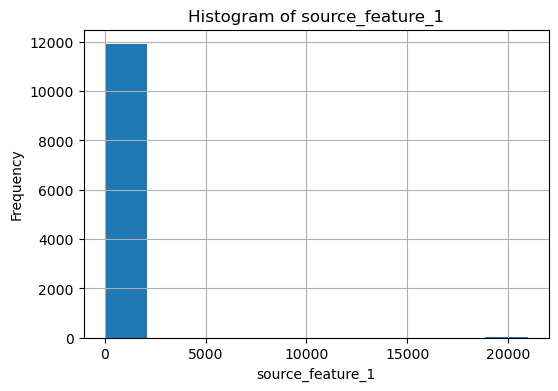

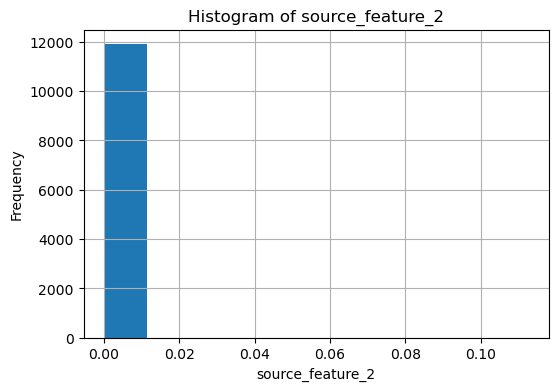

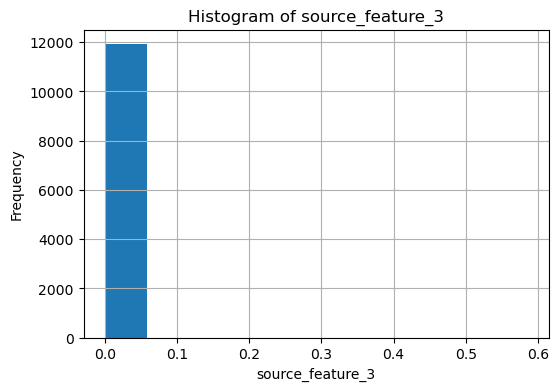

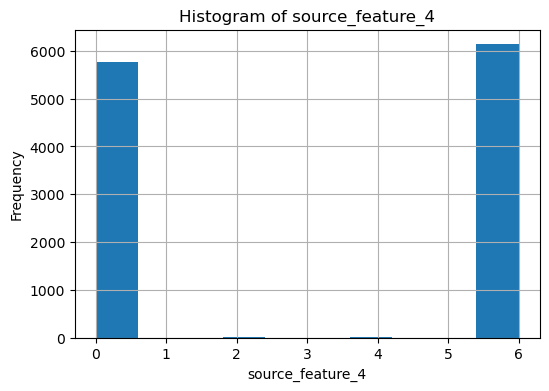

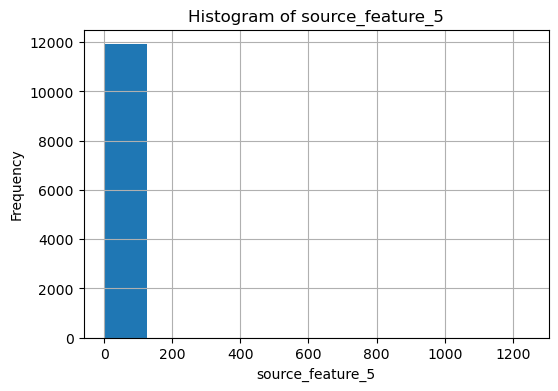

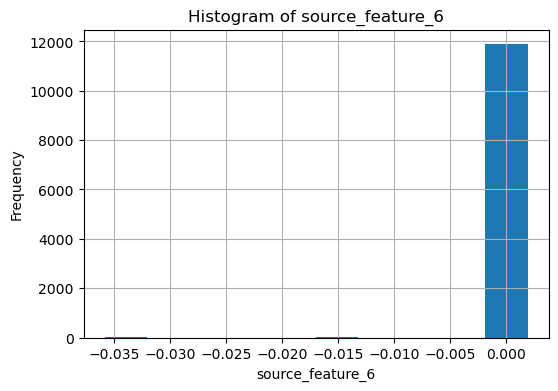

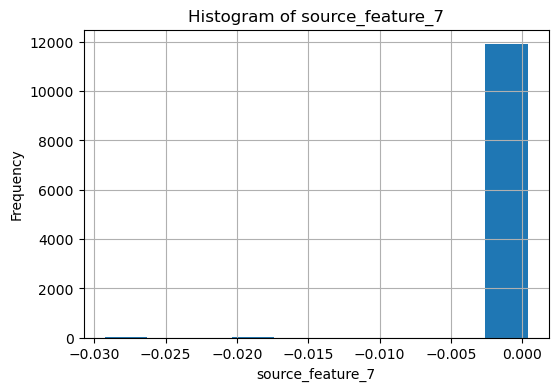

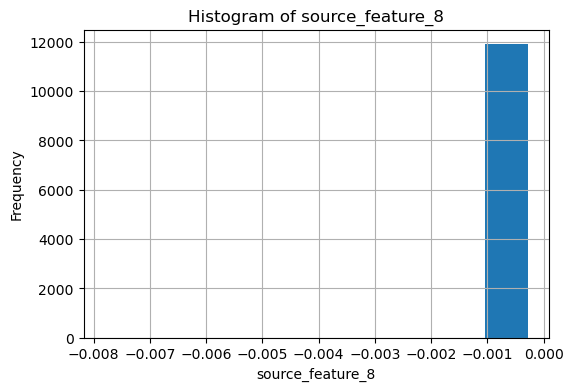

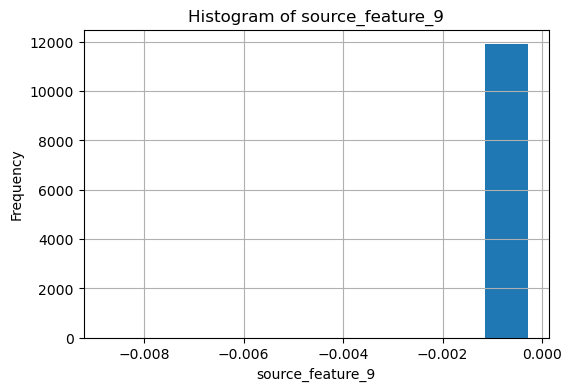

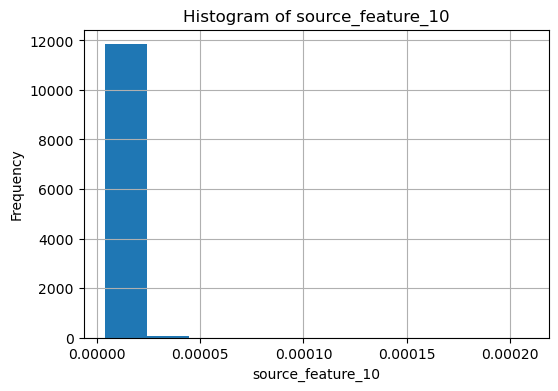

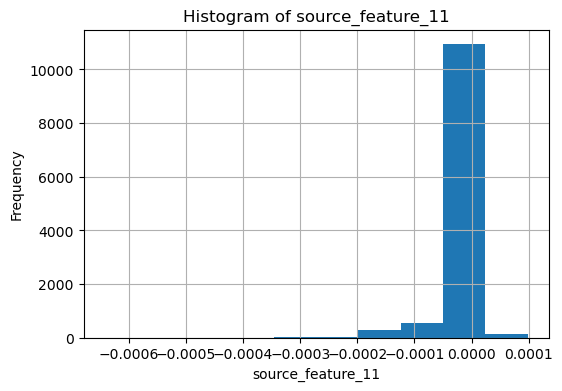

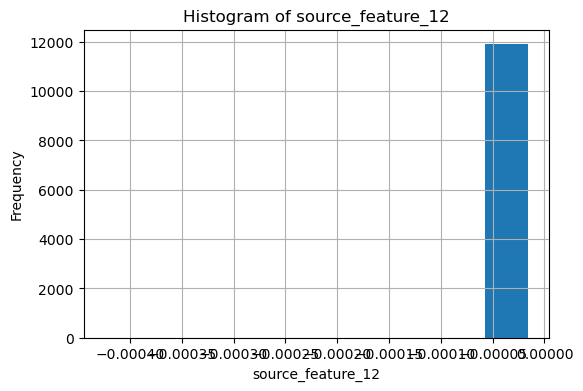

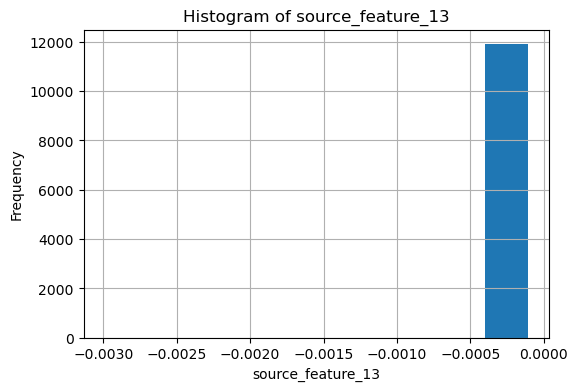

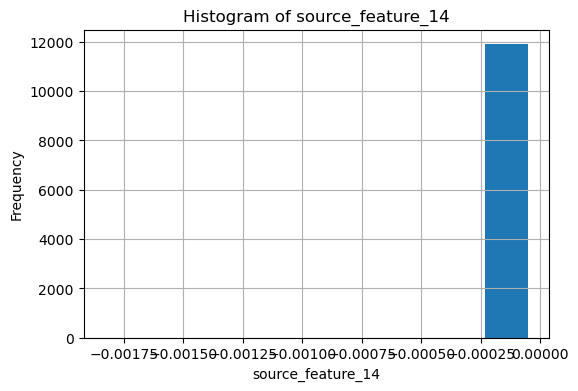

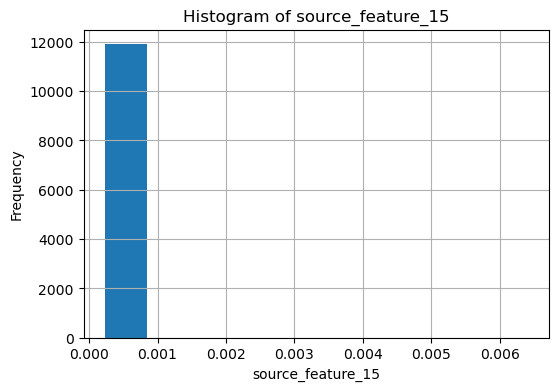

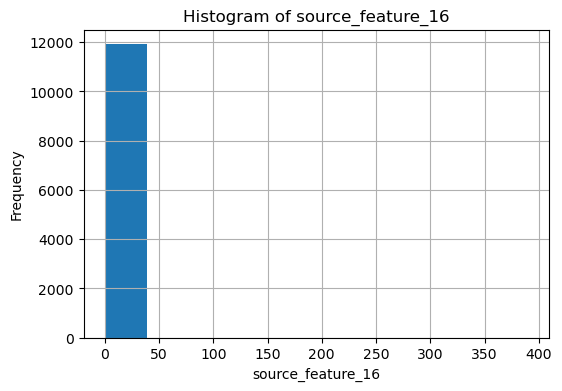

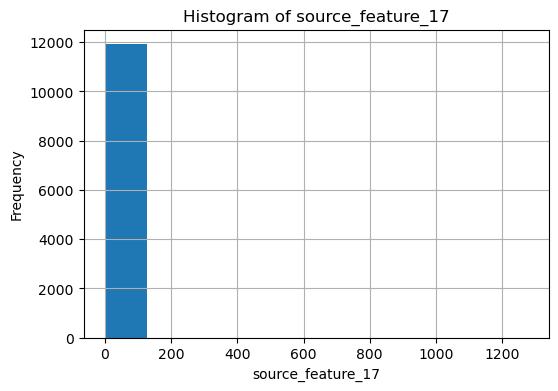

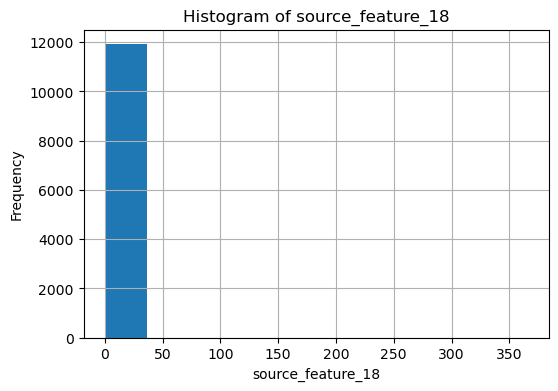

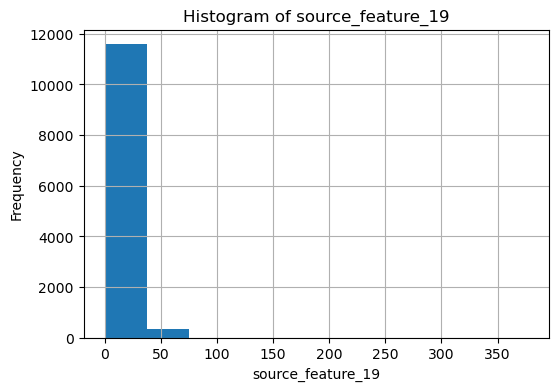

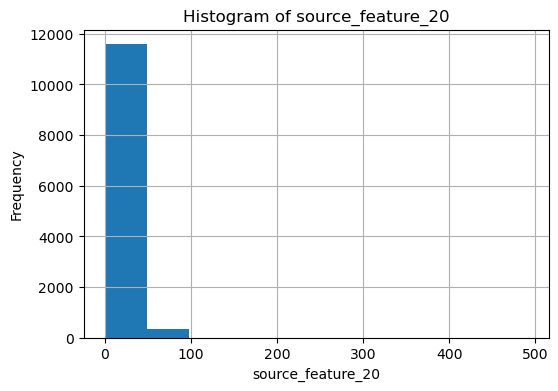

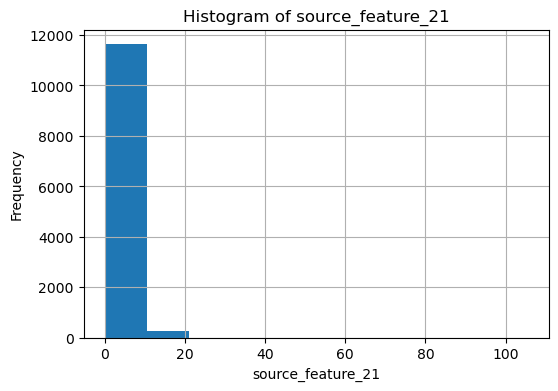

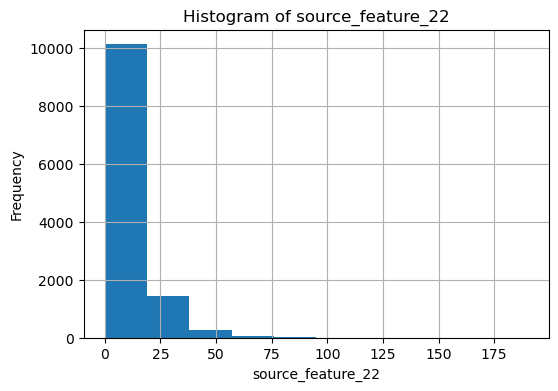

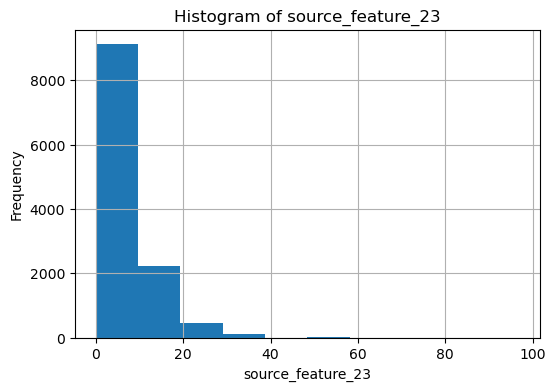

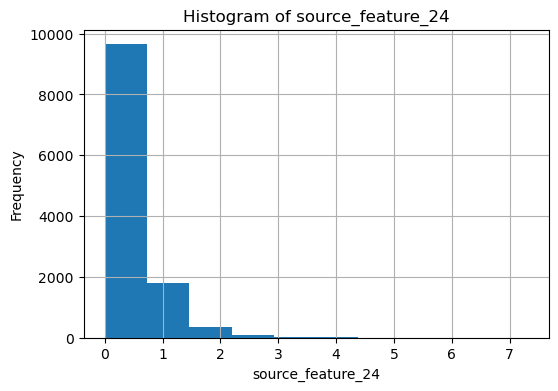

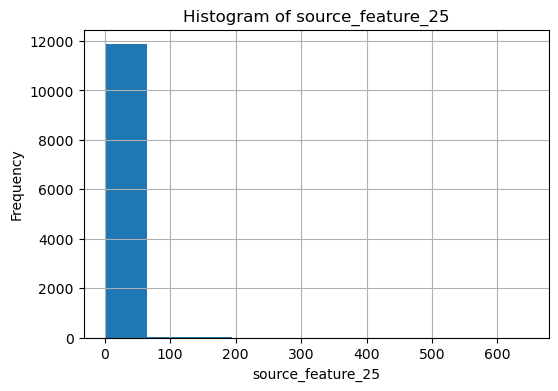

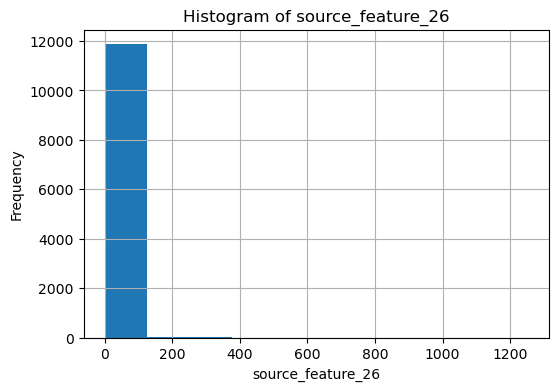

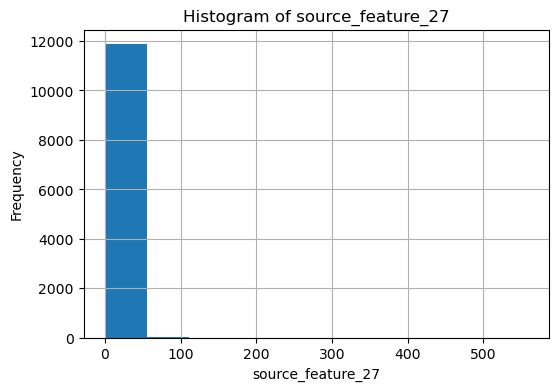

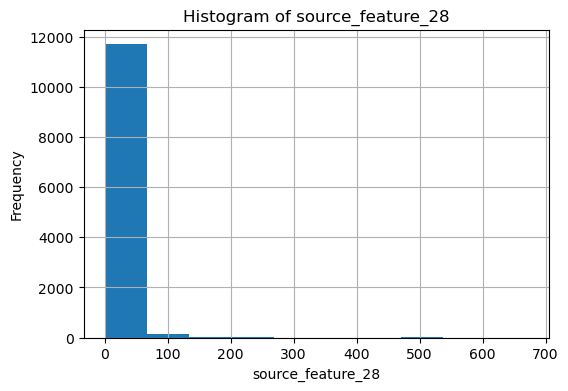

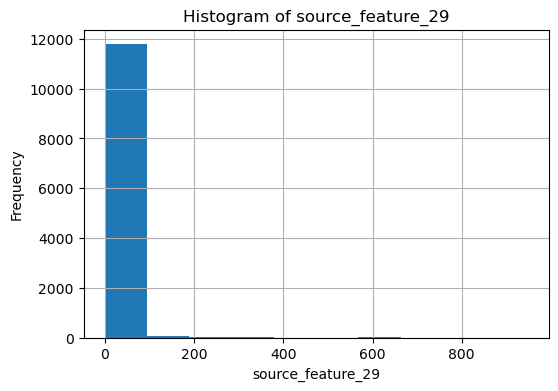

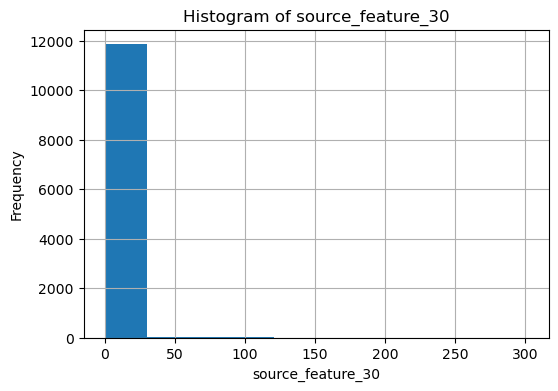

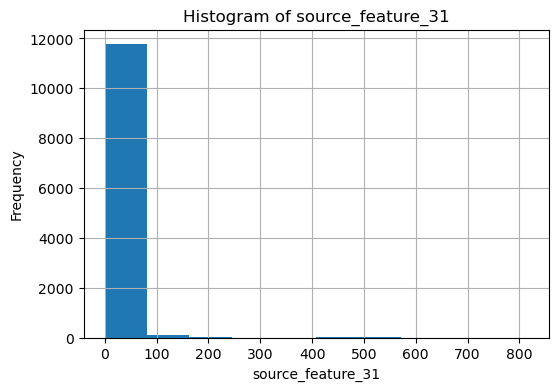

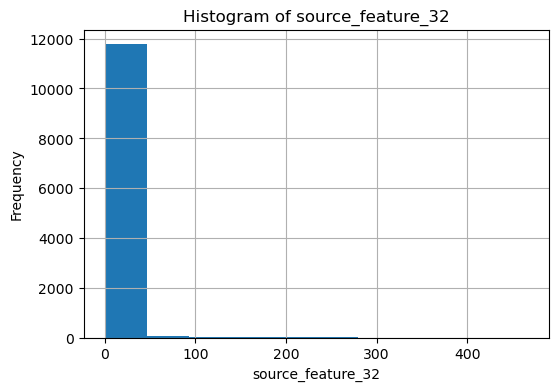

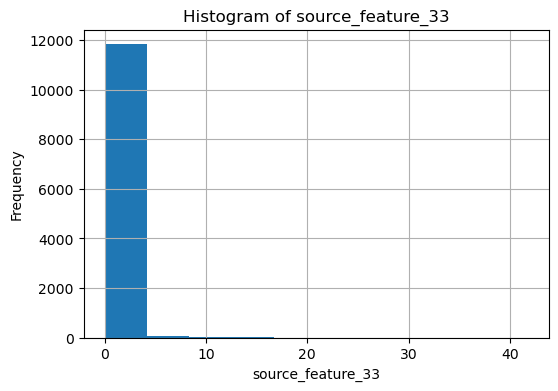

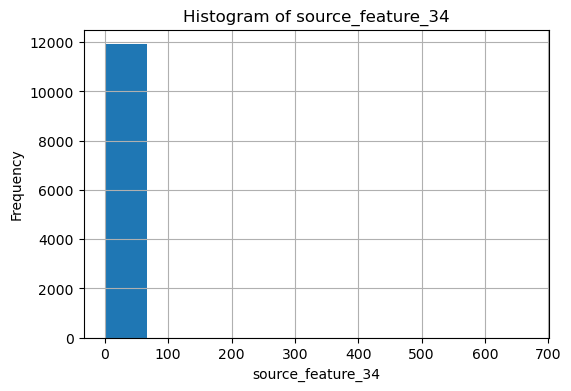

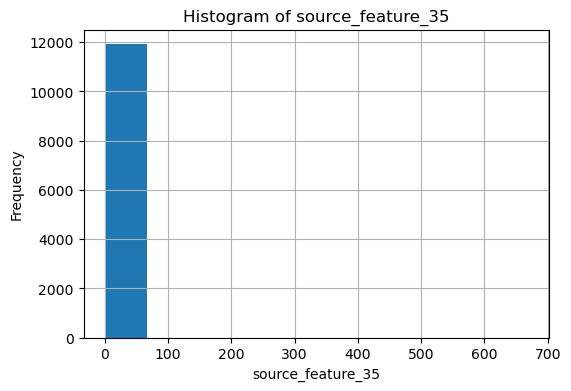

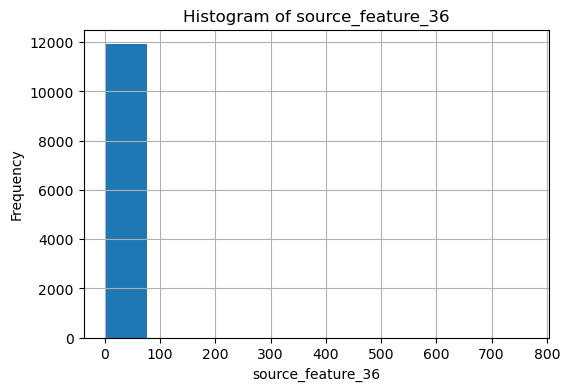

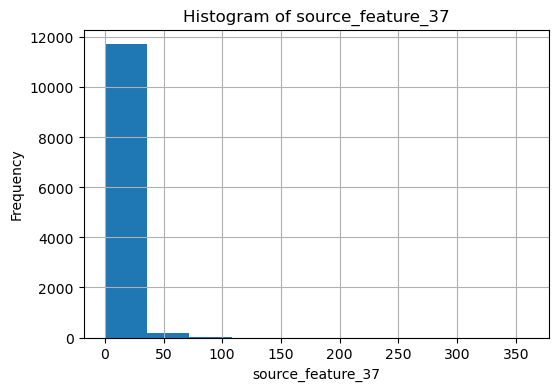

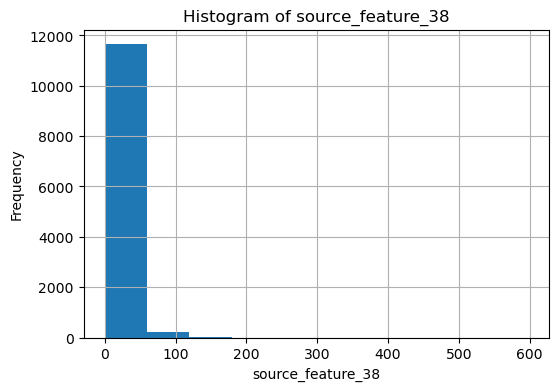

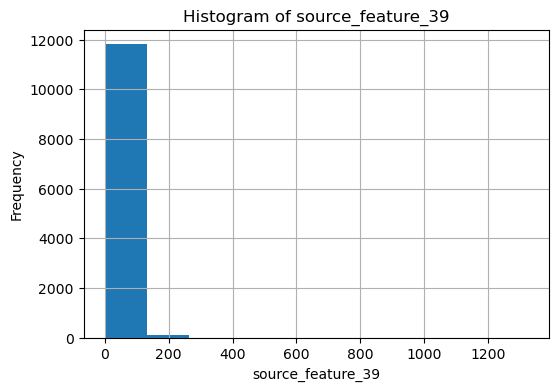

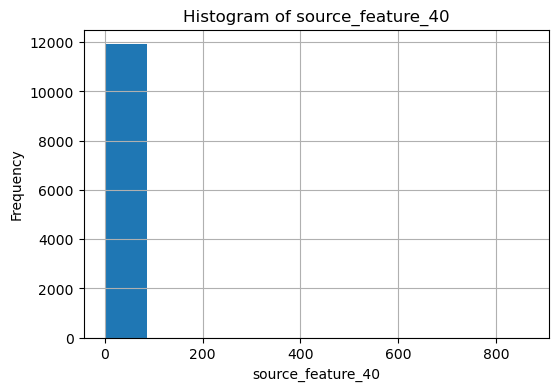

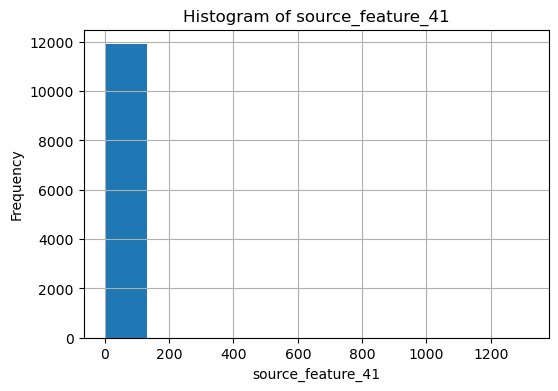

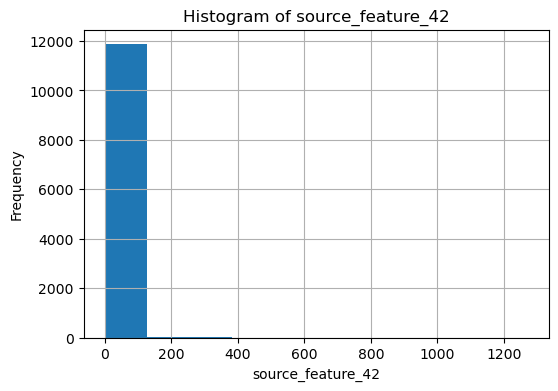

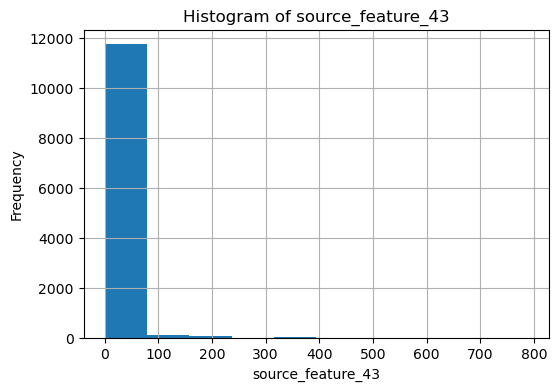

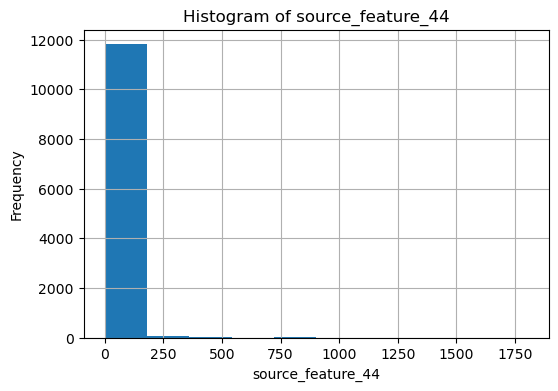

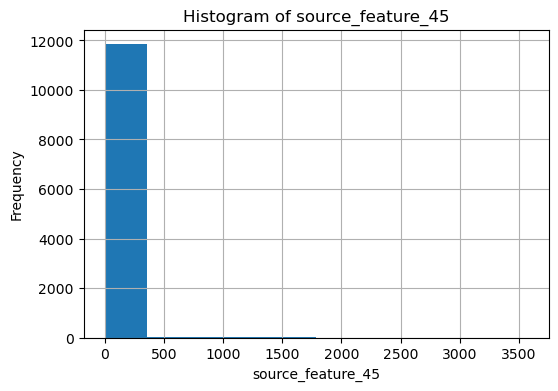

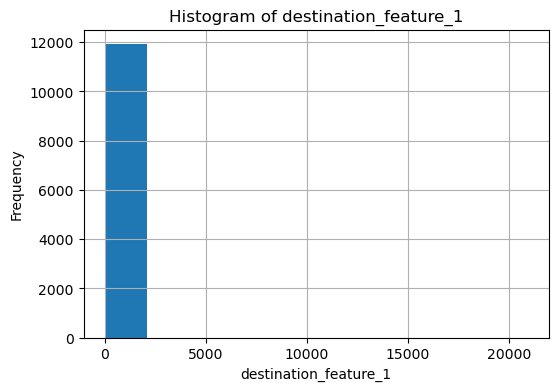

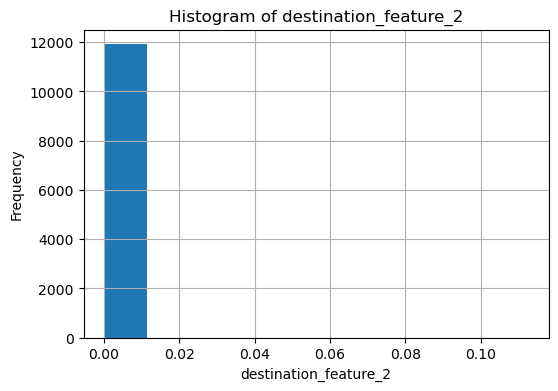

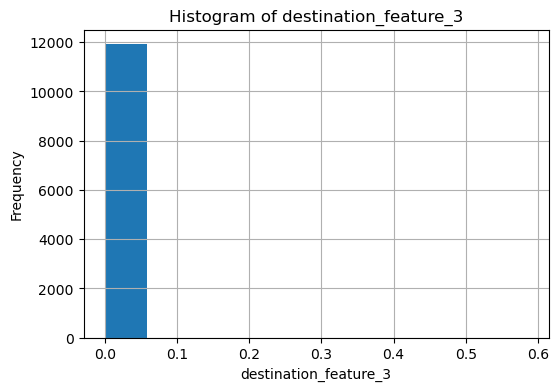

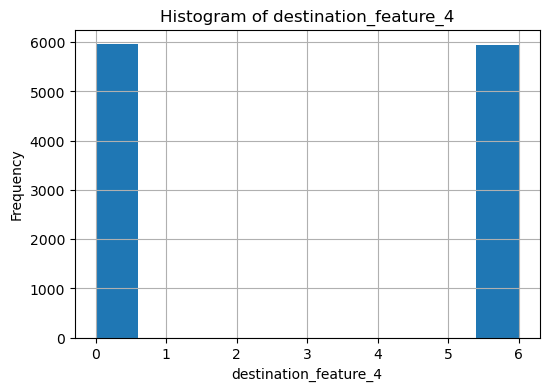

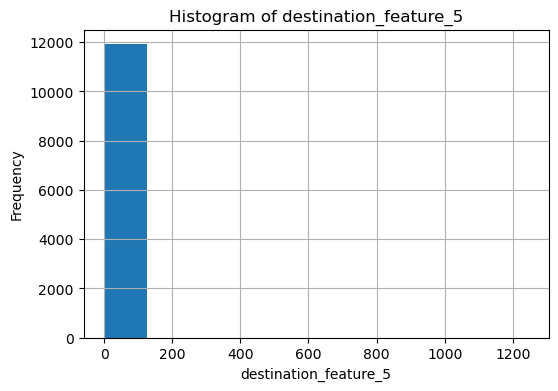

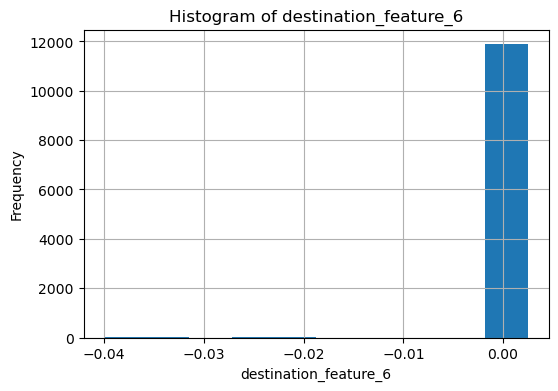

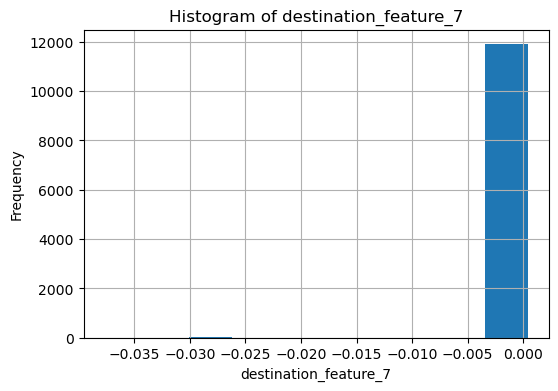

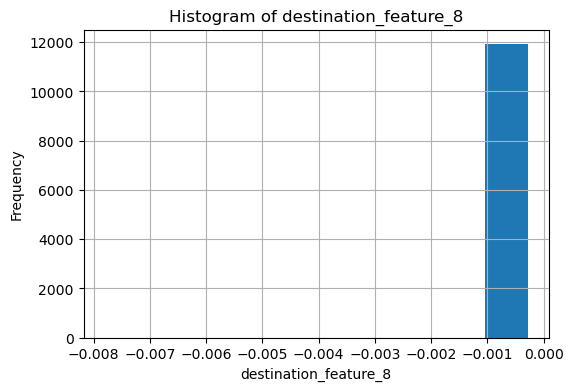

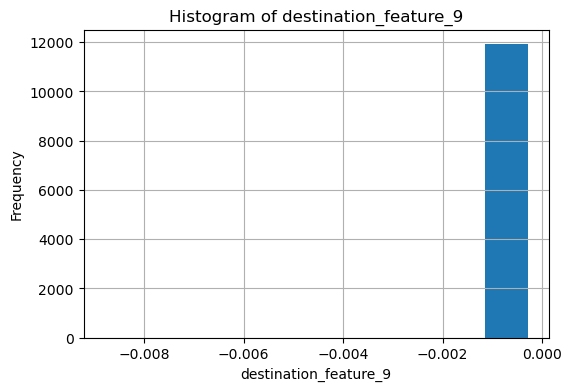

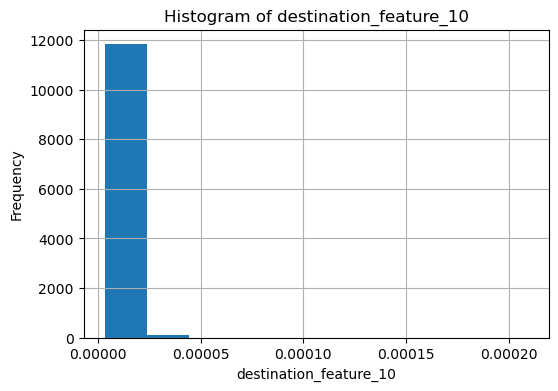

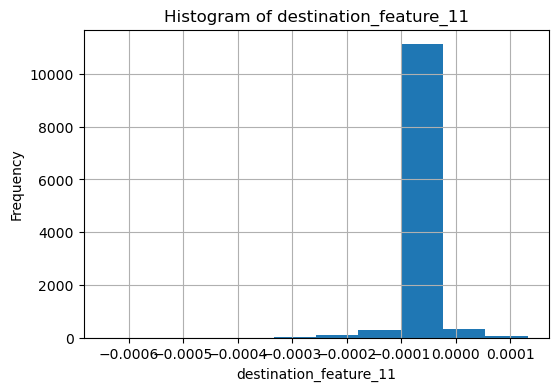

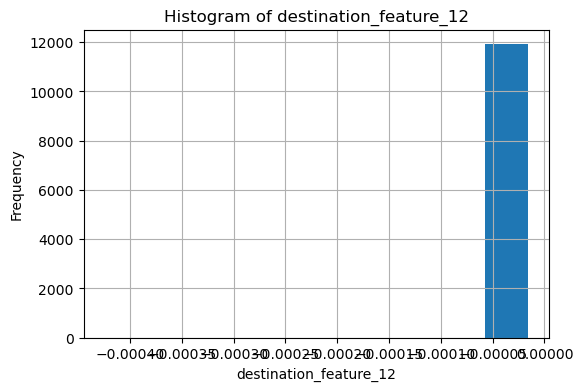

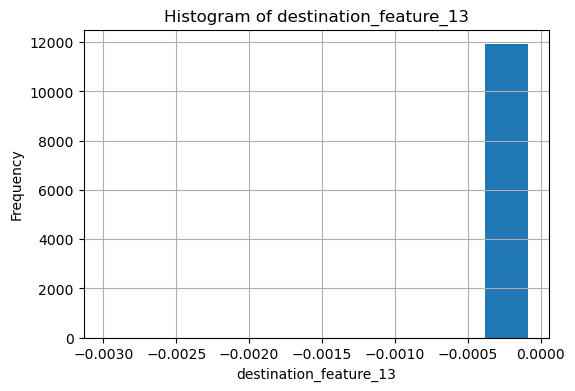

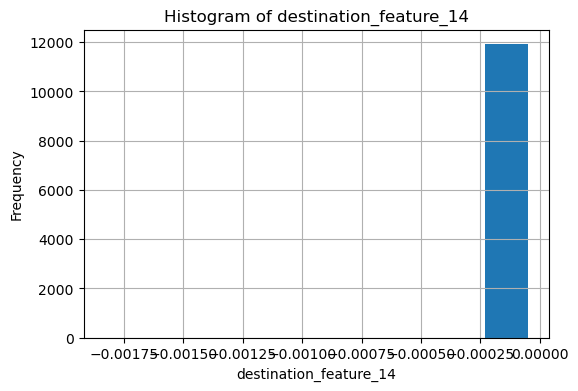

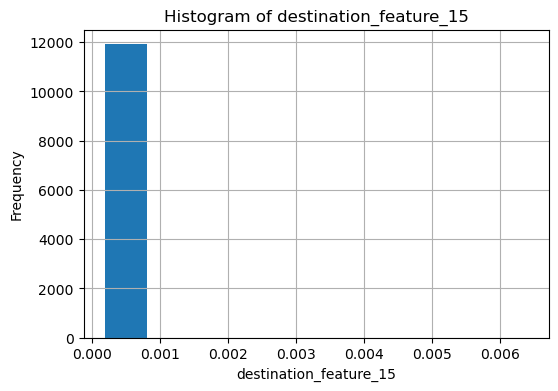

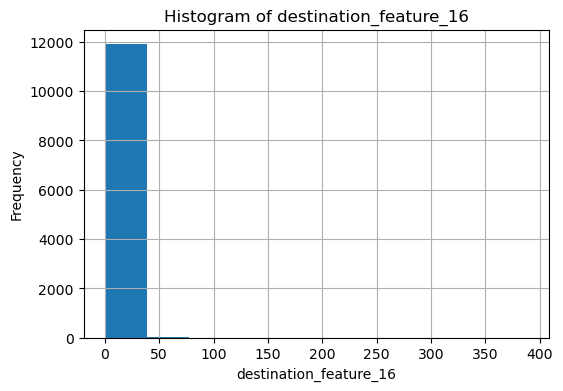

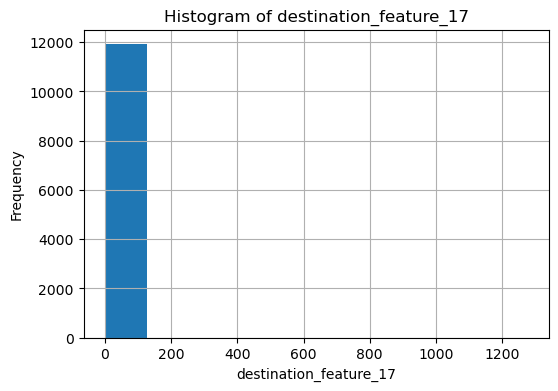

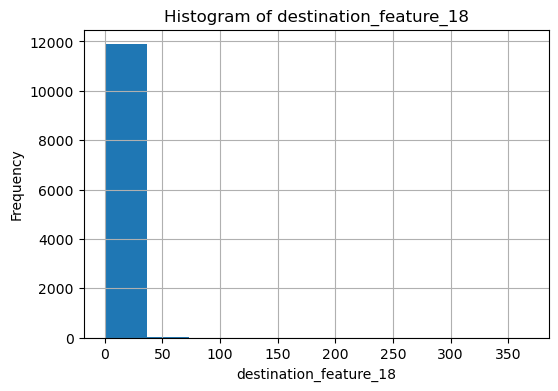

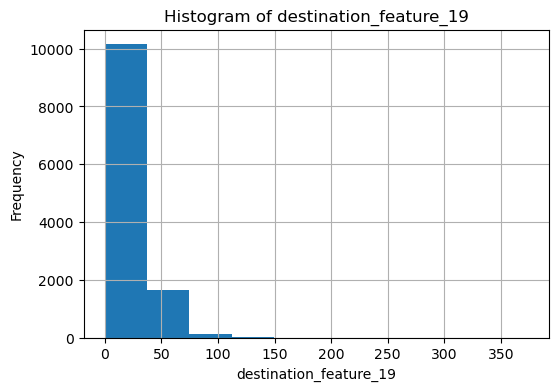

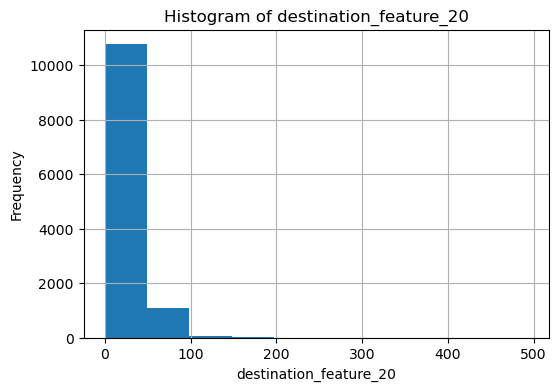

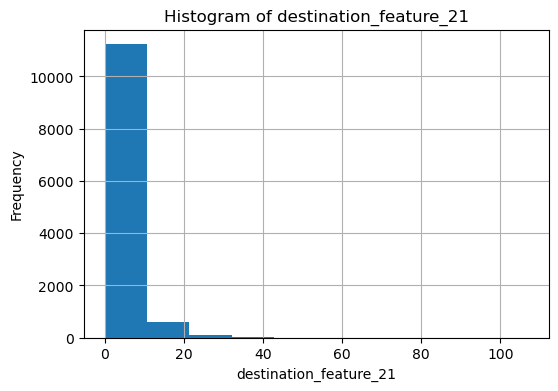

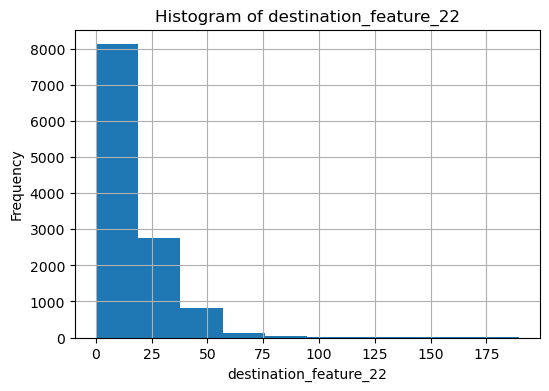

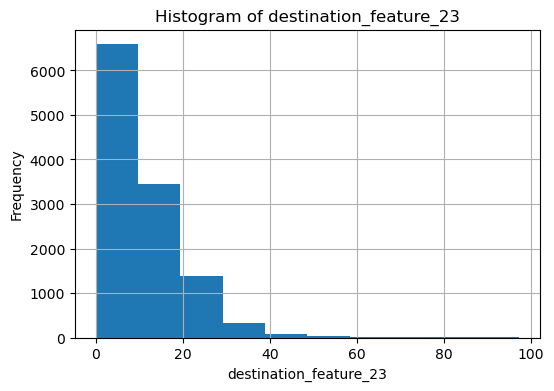

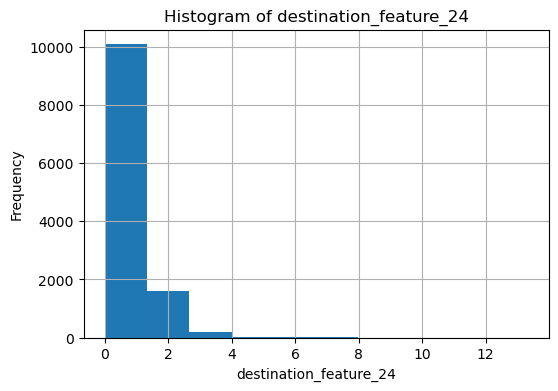

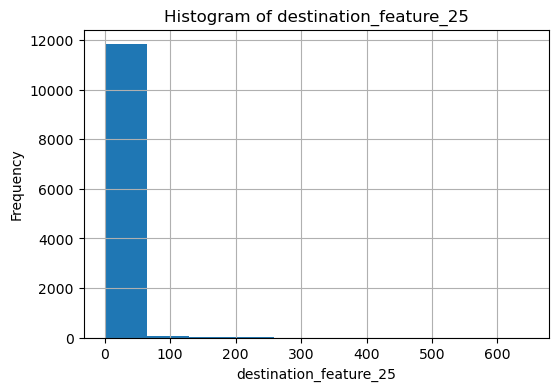

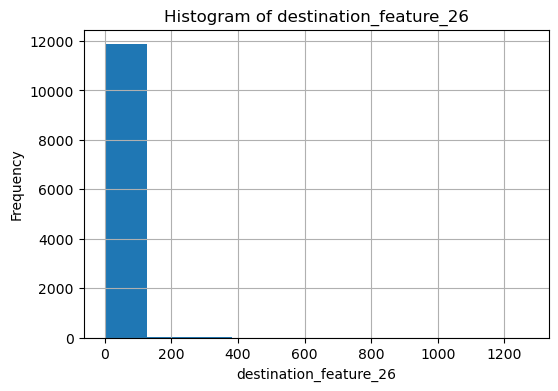

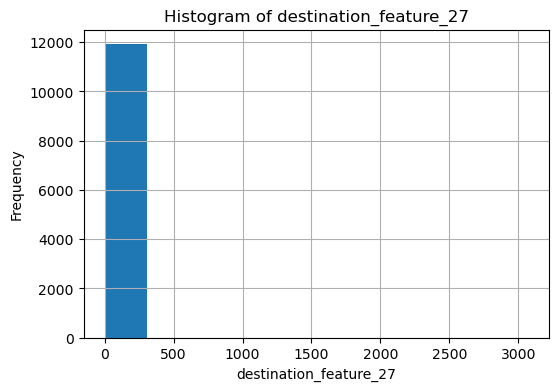

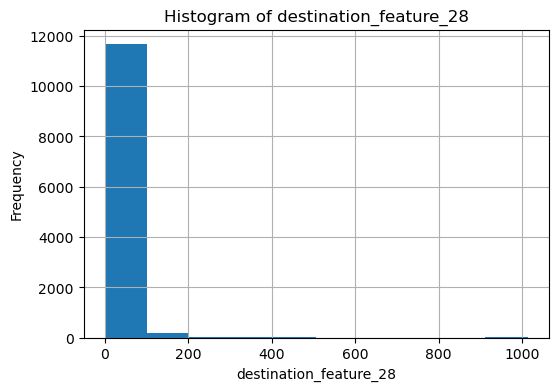

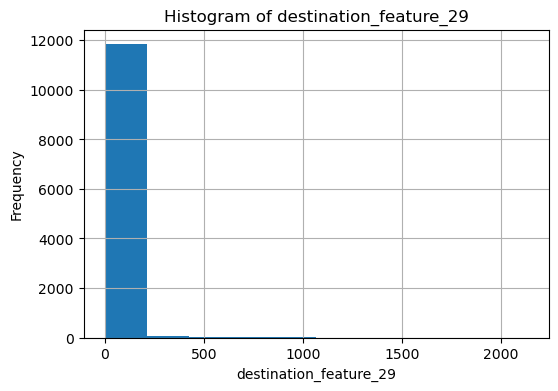

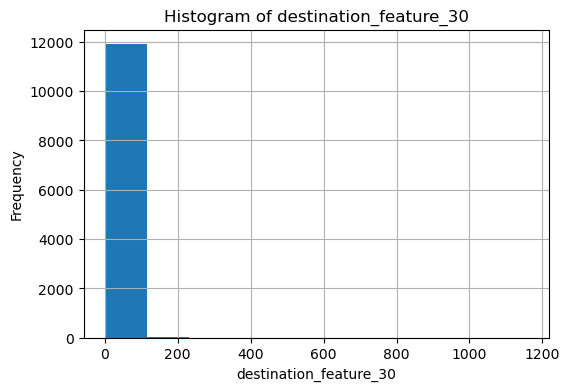

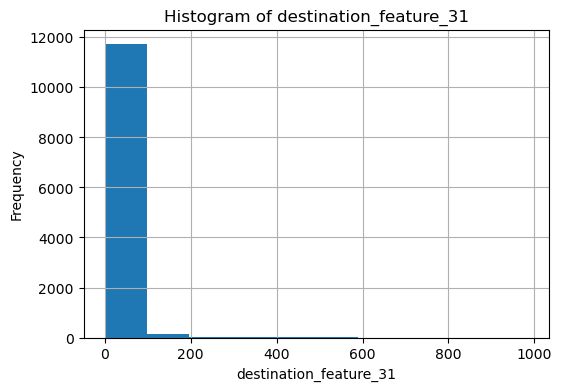

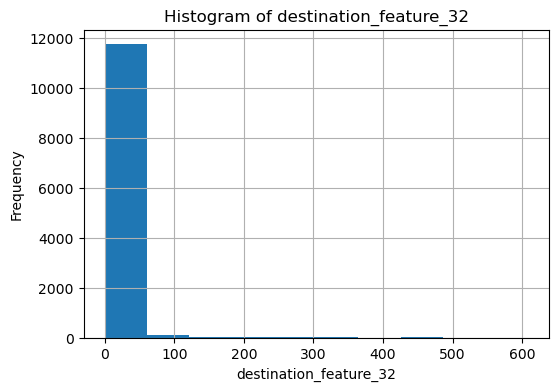

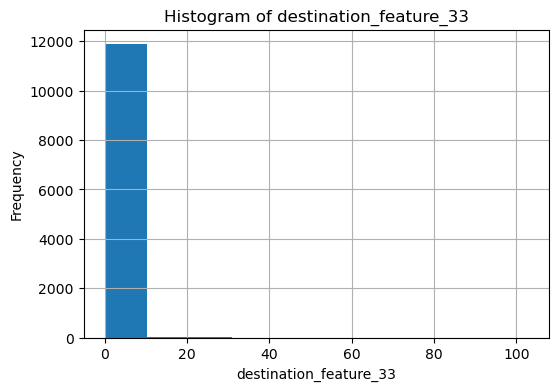

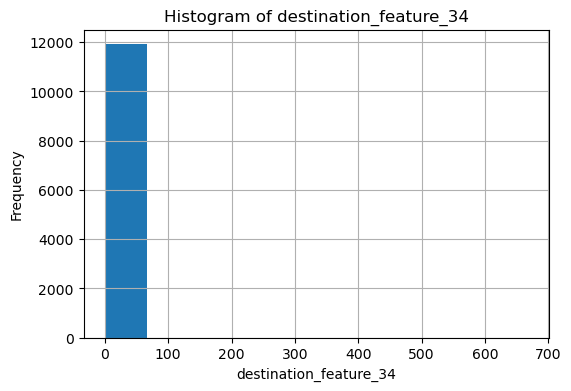

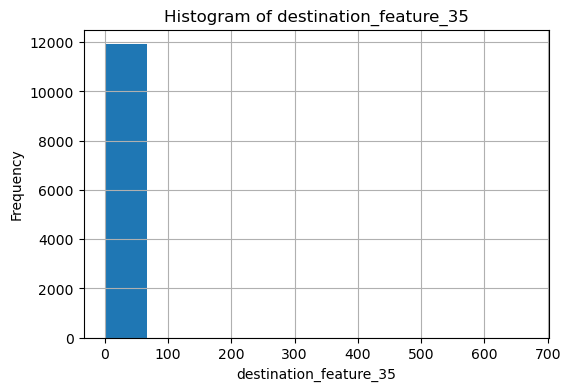

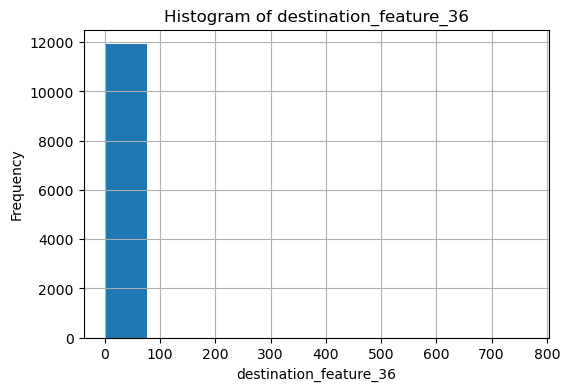

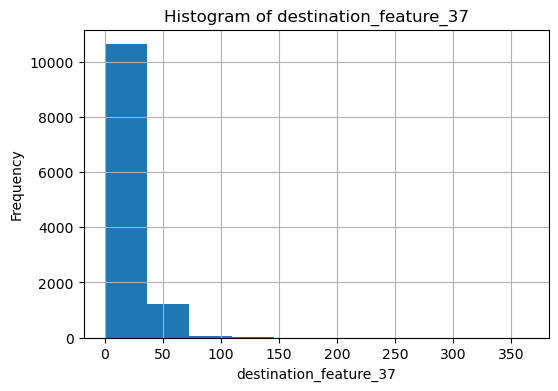

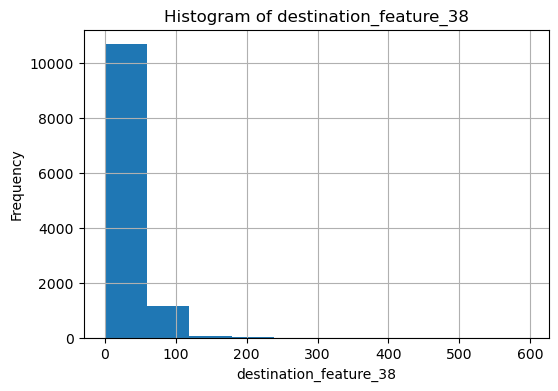

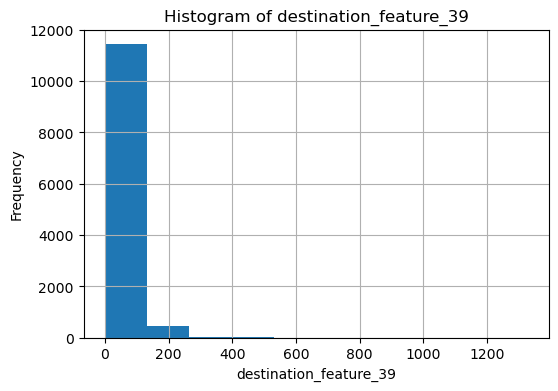

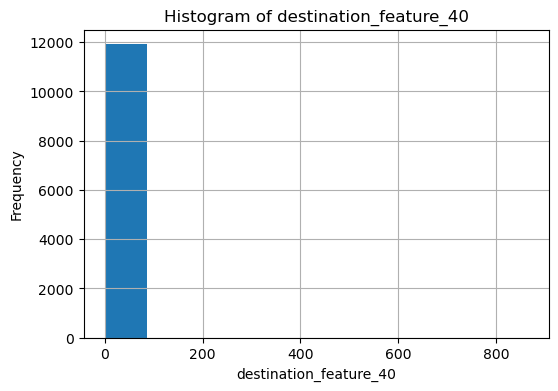

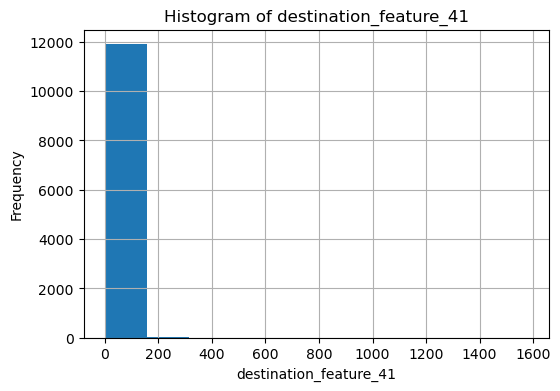

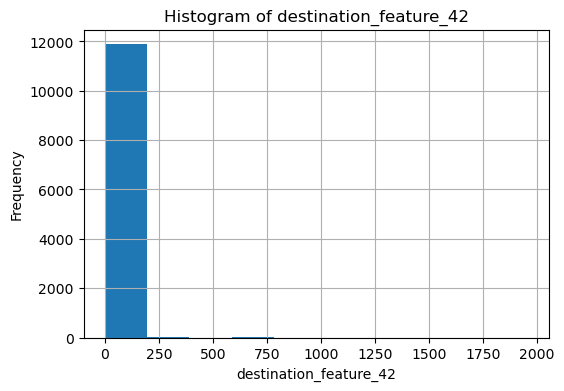

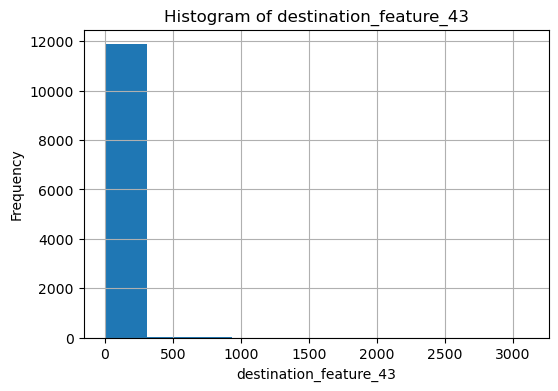

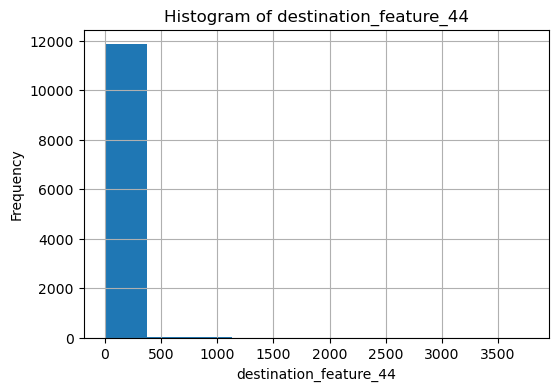

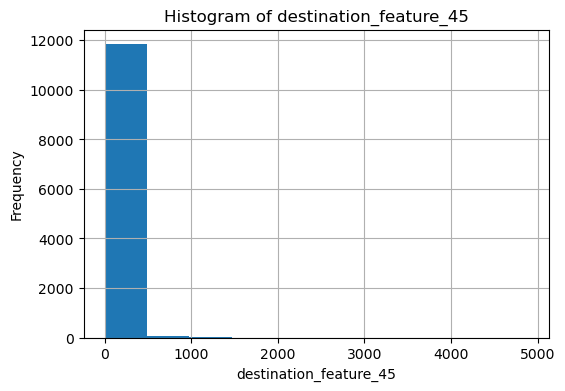

In [40]:
# Loop through each column and plot its histogram
for column in design1_feats.columns:
    plt.figure(figsize=(6, 4))  # Create a new figure for each plot
    design1_feats[column].hist(bins=10)
    plt.title(f'Histogram of {column}')  # Use f-string for dynamic title
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [42]:
design1.head()

,source,destination,design,source_feature_1,source_feature_2,source_feature_3,source_feature_4,source_feature_5,source_feature_6,source_feature_7,...,destination_feature_36,destination_feature_37,destination_feature_38,destination_feature_39,destination_feature_40,destination_feature_41,destination_feature_42,destination_feature_43,destination_feature_44,destination_feature_45
0,353995,354640,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,7.0,12.0,16.0,28.0,1.0,27.0,24.0,22.0,75.0,96.0
1,353995,597064,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,5.0,7.0,12.0,16.0,27.0,24.0,22.0,75.0,96.0,89.0
2,353995,354008,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,14.0,27.0,25.0,31.0,1.0,1.0,1.0,5.0,5.0,10.0
3,353995,354009,1,200.0,0.0003,0.0,0.0,4.0,0.000029,0.000026,...,14.0,24.0,33.0,31.0,1.0,1.0,5.0,5.0,10.0,14.0
4,380021,277279,1,64.0,0.0002,0.0,6.0,3.0,0.000023,0.000021,...,13.0,15.0,23.0,25.0,1.0,1.0,3.0,2.0,5.0,6.0


In [45]:
# Create a copy of the design1 valid pairs for analysis
d1_copy = design1.copy()

# Build a graph from the dataset
G = nx.Graph()
G.add_edges_from(d1_copy[['source', 'destination']].itertuples(index=False, name=None))

# Function to compute Jaccard similarity of neighborhoods
def jaccard_similarity(node1, node2, G):
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    if not neighbors1 and not neighbors2:
        return 0  # Avoid division by zero
    return len(neighbors1 & neighbors2) / len(neighbors1 | neighbors2)

# Compute Jaccard similarities for all valid pairs
d1_copy['neighborhood_similarity'] = d1_copy.apply(lambda row: jaccard_similarity(row['source'], row['destination'], G), axis=1)

# Display summary statistics
print(d1_copy['neighborhood_similarity'].describe())

count    11912.000000
mean         0.001298
std          0.011612
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.333333
Name: neighborhood_similarity, dtype: float64
